# GraSP Experiment — VGG-19 on CIFAR-10

Reproducing the core result from *Picking Winning Tickets Before Training by Preserving Gradient Flow* (Wang et al., 2020).

| Setting | Value |
|---|---|
| **Architecture** | VGG-19 (with BatchNorm) |
| **Dataset** | CIFAR-10 |
| **Initialization** | Kaiming Normal |
| **GraSP pruning batch** | 100 samples (10 × 10 classes) |
| **Optimizer** | SGD, momentum 0.9, weight decay 1e-4 |
| **Epochs** | 160 |
| **Batch size** | 128 |
| **Learning rate** | 0.1 → ×0.1 at epochs 80, 120 |
| **Sparsities** | 90 %, 95 %, 98 % |

We compare **Dense** (unpruned) vs several GraSP sparsity levels.

## 1 — Imports

In [1]:
import sys, os, copy, json
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
from tqdm import tqdm

# Project imports
sys.path.append(os.path.abspath('../src'))
from model import vgg19, count_parameters
from grasp import grasp, get_grasp_sparsity
from train import train_epochs, evaluate
from util import apply_masks_to_model, create_mask_apply_fn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2 — Configuration

In [2]:
config = {
    # Model / dataset
    'model':        'vgg19',
    'dataset':      'cifar10',
    'num_classes':  10,

    # GraSP pruning
    'sparsities':   [0.0, 0.90, 0.95, 0.98],   # 0.0 = dense baseline
    'samples_per_class': 10,                     # 10 × 10 classes = 100 samples
    'grasp_T':      200,                         # temperature scaling
    'grasp_iters':  1,                            # number of balanced batches

    # Training
    'epochs':       160,
    'batch_size':   128,
    'lr':           0.1,
    'momentum':     0.9,
    'weight_decay': 1e-4,
    'lr_milestones': [80, 120],
    'lr_gamma':     0.1,

    # Reproducibility
    'seed':         42,

    # Output
    'results_dir':  '../results/grasp',
}

print("=" * 60)
print("EXPERIMENT CONFIGURATION")
print("=" * 60)
for k, v in config.items():
    print(f"  {k:>20s}: {v}")
print("=" * 60)

EXPERIMENT CONFIGURATION
                 model: vgg19
               dataset: cifar10
           num_classes: 10
            sparsities: [0.0, 0.9, 0.95, 0.98]
     samples_per_class: 10
               grasp_T: 200
           grasp_iters: 1
                epochs: 160
            batch_size: 128
                    lr: 0.1
              momentum: 0.9
          weight_decay: 0.0001
         lr_milestones: [80, 120]
              lr_gamma: 0.1
                  seed: 42
           results_dir: ../results/grasp


## 3 — Dataset

In [3]:
# CIFAR-10 transforms (standard augmentation for training)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                          (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                          (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'],
                          shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=256,
                          shuffle=False, num_workers=2, pin_memory=True)

print(f"Training samples : {len(train_dataset):,}")
print(f"Test samples     : {len(test_dataset):,}")
print(f"Training batches : {len(train_loader)}")

100%|████████████████████████████████████████| 170M/170M [00:10<00:00, 15.7MB/s]


Training samples : 50,000
Test samples     : 10,000
Training batches : 391


## 4 — Helper: train one configuration end-to-end

Encapsulates: model init → (optional) GraSP pruning → full 160-epoch training.

In [4]:
def run_experiment(sparsity: float, config: dict):
    """Create model, optionally apply GraSP, then train for 160 epochs.

    Returns a dict with training history, final accuracy, and mask info.
    """
    torch.manual_seed(config['seed'])
    np.random.seed(config['seed'])
    torch.cuda.manual_seed_all(config['seed'])

    # ---- Model (Kaiming Normal init) ----
    model = vgg19(num_classes=config['num_classes']).to(device)

    # Apply Kaiming Normal to all Conv2d layers
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    params = count_parameters(model)
    tag = f"dense" if sparsity == 0.0 else f"sparse_{sparsity}"
    print(f"\n{'='*60}")
    print(f"[{tag}]  sparsity = {sparsity*100:.0f}%")
    print(f"  Total params: {params['total']:,}")

    # ---- GraSP pruning (skip for dense baseline) ----
    masks = None
    apply_fn = None

    if sparsity > 0:
        print(f"  Running GraSP (T={config['grasp_T']}, "
              f"samples={config['samples_per_class']*config['num_classes']}) …")
        masks = grasp(
            model, train_loader, device,
            sparsity=sparsity,
            num_classes=config['num_classes'],
            samples_per_class=config['samples_per_class'],
            num_iters=config['grasp_iters'],
            T=config['grasp_T'],
        )
        layer_sparsity = get_grasp_sparsity(masks)
        print(f"  Achieved overall sparsity: {layer_sparsity['overall']*100:.2f}%")
        for name, sp in layer_sparsity.items():
            if name != 'overall':
                print(f"    {name:>30s}: {sp*100:.2f}%")

        # Build mask-application closure
        apply_fn = create_mask_apply_fn(model)

    # ---- Optimizer / scheduler ----
    optimizer = optim.SGD(
        model.parameters(),
        lr=config['lr'],
        momentum=config['momentum'],
        weight_decay=config['weight_decay'],
    )
    scheduler = MultiStepLR(optimizer,
                            milestones=config['lr_milestones'],
                            gamma=config['lr_gamma'])
    criterion = nn.CrossEntropyLoss()

    # ---- Train ----
    print(f"  Training for {config['epochs']} epochs …")
    history = train_epochs(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=config['epochs'],
        device=device,
        scheduler=scheduler,
        masks=masks,
        apply_mask_fn=apply_fn,
        verbose=True,
    )

    best_test = max(history['test_accs'])
    final_test = history['final_test_acc']
    print(f"  ✓ Done — best test acc: {best_test:.2f}%, "
          f"final test acc: {final_test:.2f}%")

    return {
        'sparsity': sparsity,
        'history': history,
        'best_test_acc': best_test,
        'final_test_acc': final_test,
        'masks': masks,
    }

## 5 — Run experiments

Train the dense baseline and each GraSP sparsity level sequentially.
This is the long-running cell (≈ 4 × 160 epochs).

In [5]:
all_results = {}

for sparsity in config['sparsities']:
    tag = "dense" if sparsity == 0.0 else f"{sparsity*100:.0f}%"
    result = run_experiment(sparsity, config)
    all_results[tag] = result

# ---------- save results to disk ----------
os.makedirs(config['results_dir'], exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join(config['results_dir'], f"grasp_vgg19_cifar10_{timestamp}.json")

serialisable = {}
for tag, res in all_results.items():
    serialisable[tag] = {
        'sparsity': res['sparsity'],
        'best_test_acc': res['best_test_acc'],
        'final_test_acc': res['final_test_acc'],
        'test_accs': res['history']['test_accs'],
        'train_accs': res['history']['train_accs'],
        'train_losses': res['history']['train_losses'],
    }

with open(save_path, 'w') as f:
    json.dump(serialisable, f, indent=2)

print(f"\nResults saved to {save_path}")
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"{'Sparsity':>12s}  {'Best Test Acc':>14s}  {'Final Test Acc':>14s}")
print("-" * 44)
for tag, res in all_results.items():
    print(f"{tag:>12s}  {res['best_test_acc']:>13.2f}%  {res['final_test_acc']:>13.2f}%")


[dense]  sparsity = 0%
  Total params: 20,565,834
  Training for 160 epochs …


Training: 100%|█| 160/160 [46:25<00:00, 17.41s/it, train_loss=nan, train_acc=10.

  ✓ Done — best test acc: 10.00%, final test acc: 10.00%

[sparse_0.9]  sparsity = 90%
  Total params: 20,565,834
  Running GraSP (T=200, samples=100) …


  Achieved overall sparsity: 90.00%
                        features.0: 51.74%
                        features.3: 58.39%
                        features.7: 61.81%
                       features.10: 66.36%
                       features.14: 71.51%
                       features.17: 77.72%
                       features.20: 78.96%
                       features.23: 79.99%
                       features.27: 85.87%
                       features.30: 91.33%
                       features.33: 91.69%
                       features.36: 92.02%
                       features.40: 92.30%
                       features.43: 93.21%
                       features.46: 93.26%
                       features.49: 93.90%
                      classifier.1: 80.27%
                      classifier.4: 81.21%
                      classifier.6: 59.14%
  Training for 160 epochs …


Training: 100%|█| 160/160 [1:07:48<00:00, 25.43s/it, train_loss=0.0128, train_ac

  ✓ Done — best test acc: 91.87%, final test acc: 91.76%

[sparse_0.95]  sparsity = 95%
  Total params: 20,565,834
  Running GraSP (T=200, samples=100) …


  Achieved overall sparsity: 95.00%
                        features.0: 53.36%
                        features.3: 62.25%
                        features.7: 66.87%
                       features.10: 72.64%
                       features.14: 78.78%
                       features.17: 85.45%
                       features.20: 86.63%
                       features.23: 87.69%
                       features.27: 92.74%
                       features.30: 96.54%
                       features.33: 96.78%
                       features.36: 96.99%
                       features.40: 96.82%
                       features.43: 97.17%
                       features.46: 97.27%
                       features.49: 97.45%
                      classifier.1: 87.14%
                      classifier.4: 87.88%
                      classifier.6: 62.73%
  Training for 160 epochs …


Training: 100%|█| 160/160 [1:08:01<00:00, 25.51s/it, train_loss=0.0144, train_ac

  ✓ Done — best test acc: 91.95%, final test acc: 91.77%

[sparse_0.98]  sparsity = 98%
  Total params: 20,565,834
  Running GraSP (T=200, samples=100) …


  Achieved overall sparsity: 98.00%
                        features.0: 55.27%
                        features.3: 67.57%
                        features.7: 73.22%
                       features.10: 80.13%
                       features.14: 86.50%
                       features.17: 92.50%
                       features.20: 93.44%
                       features.23: 94.27%
                       features.27: 97.42%
                       features.30: 99.16%
                       features.33: 99.26%
                       features.36: 99.34%
                       features.40: 99.15%
                       features.43: 99.22%
                       features.46: 99.28%
                       features.49: 99.27%
                      classifier.1: 93.13%
                      classifier.4: 93.58%
                      classifier.6: 67.99%
  Training for 160 epochs …


Training: 100%|█| 160/160 [1:07:58<00:00, 25.49s/it, train_loss=0.0414, train_ac

  ✓ Done — best test acc: 91.30%, final test acc: 91.14%

Results saved to ../results/grasp/grasp_vgg19_cifar10_20260215_131057.json

SUMMARY
    Sparsity   Best Test Acc  Final Test Acc
--------------------------------------------
       dense          10.00%          10.00%
         90%          91.87%          91.76%
         95%          91.95%          91.77%
         98%          91.30%          91.14%


## 6 — Visualise results

**Left**: test accuracy curves over 160 epochs for each sparsity level.
**Right**: best test accuracy vs sparsity (the key plot for comparing with the paper).

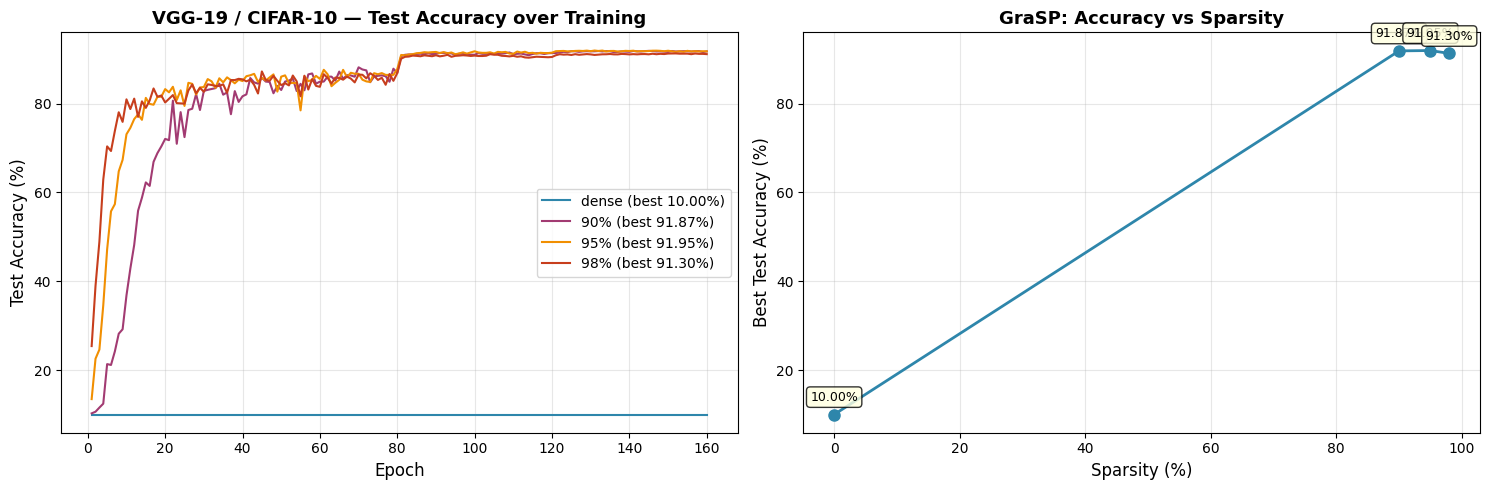


FINAL RESULTS TABLE
    Sparsity   Best Test Acc  Final Test Acc
--------------------------------------------
       dense          10.00%          10.00%
         90%          91.87%          91.76%
         95%          91.95%          91.77%
         98%          91.30%          91.14%


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

colors = {
    'dense':  '#2E86AB',
    '90%':    '#A23B72',
    '95%':    '#F18F01',
    '98%':    '#C73E1D',
}

# ---- Plot 1: test accuracy over epochs ----
for tag, res in all_results.items():
    epochs = range(1, len(res['history']['test_accs']) + 1)
    ax1.plot(epochs, res['history']['test_accs'],
             label=f"{tag} (best {res['best_test_acc']:.2f}%)",
             color=colors.get(tag, 'gray'), linewidth=1.5)

ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Test Accuracy (%)', fontsize=12)
ax1.set_title('VGG-19 / CIFAR-10 — Test Accuracy over Training', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# ---- Plot 2: best accuracy vs sparsity ----
sparsities_pct = []
best_accs = []
for tag, res in all_results.items():
    sp = res['sparsity'] * 100
    sparsities_pct.append(sp)
    best_accs.append(res['best_test_acc'])

ax2.plot(sparsities_pct, best_accs, 'o-', linewidth=2, markersize=8, color='#2E86AB')
for sp, acc in zip(sparsities_pct, best_accs):
    ax2.annotate(f'{acc:.2f}%', (sp, acc), textcoords='offset points',
                 xytext=(0, 10), ha='center', fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.3', fc='lightyellow', alpha=0.8))

ax2.set_xlabel('Sparsity (%)', fontsize=12)
ax2.set_ylabel('Best Test Accuracy (%)', fontsize=12)
ax2.set_title('GraSP: Accuracy vs Sparsity', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config['results_dir'], 'grasp_vgg19_cifar10.png'), dpi=150, bbox_inches='tight')
plt.show()

# Final table
print("\n" + "=" * 60)
print("FINAL RESULTS TABLE")
print("=" * 60)
print(f"{'Sparsity':>12s}  {'Best Test Acc':>14s}  {'Final Test Acc':>14s}")
print("-" * 44)
for tag, res in all_results.items():
    print(f"{tag:>12s}  {res['best_test_acc']:>13.2f}%  {res['final_test_acc']:>13.2f}%")